**Taller 5**

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegFileWriter
from scipy.ndimage import generate_binary_structure
from scipy.ndimage import convolve
import numba

Punto 1


In [ ]:
#TEMP

Punto 2

In [ ]:
#TEMP

Punto 3

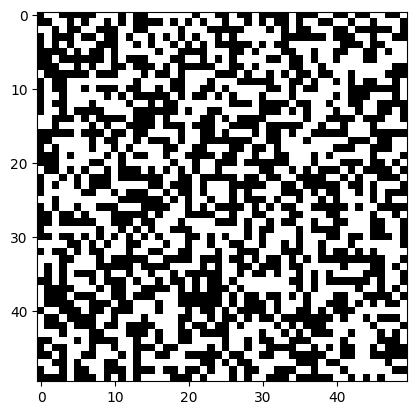

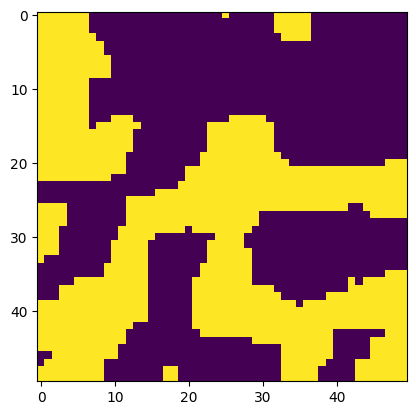

In [63]:
#Definir parametros
N = 50
J = 0.2
beta = 10

#Definir estado inicial del sistema
estado0 = np.random.randint(2, size=(N, N))
for i in range(len(estado0)):
    for j in range(len(estado0[i])):
        if estado0[i][j] == 0:
            estado0[i][j] = -1
#Muy ineficiente, solo prueba concepto, cambiar

#Calcular energia originial
"""""def energia(array, J):
    s = 0
    for i in range(len(array)):
        for j in range(len(array[i])):
            if i == 149:
                i = 0
            if j == 149:
                j = 0
            s += array[i][j]*array[i+1][j]+array[i][j]*array[i][j+1]+array[i][j]*array[i-1][j]+array[i][j]*array[i][j-1]
    return -J*s"""""

def energia(array, J):
    kernel = generate_binary_structure(2, 1)
    kernel[1][1] = False
    resultado = -J * array * convolve(array, kernel, mode="constant", cval=0)
    return resultado.sum()

#Inicializar gráfico
metadata = dict(title="Muestra Solucíon Animada", artist="Yo")
writer = FFMpegFileWriter(fps=15, metadata=metadata)

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(estado0, cmap="Greys",  interpolation="nearest")
plt.show()

for i in range(40000):
    #Calular energia inical
    Eo = energia(estado0, J)

    #Sacar posición aleatoria en el array
    rand = np.random.randint(N, size=(2))

    #Cambiar el valor de la posición
    estado1 = estado0.copy()
    estado1[rand[0], rand[1]] *= -1

    #Calcular la energia nueva
    En = energia(estado1, J)

    #Aplicar condiciones
    dE = En - Eo

    if dE <= 0 or np.random.random() < np.exp(-beta * dE):
        estado0 = estado1

plt.imshow(estado1)
plt.show()


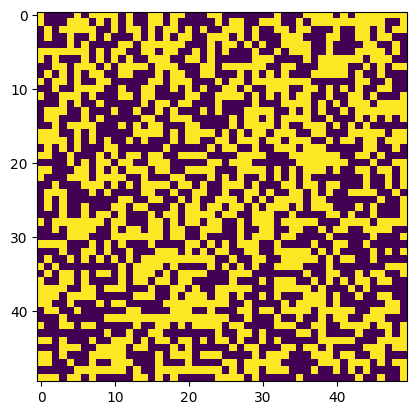

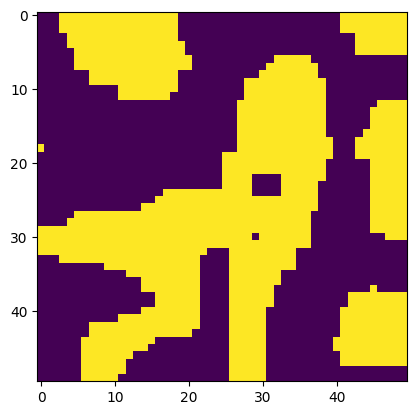

In [70]:
#Definir parametros
N = 50
J = 0.2
beta = 10

#Definir estado inicial del sistema
estado0 = np.random.randint(2, size=(N, N))
for i in range(len(estado0)):
    for j in range(len(estado0[i])):
        if estado0[i][j] == 0:
            estado0[i][j] = -1
#Muy ineficiente, solo prueba concepto, cambiar
plt.imshow(estado0)
plt.show()
#Calcular energia originial

def energia(array, J):
    kernel = generate_binary_structure(2, 1)
    kernel[1][1] = False
    resultado = -J * array * convolve(array, kernel, mode="constant", cval=0)
    return resultado.sum()

#Inicializar gráfico
metadata = dict(title="Muestra Solucíon Animada", artist="Yo")
writer = FFMpegFileWriter(fps=5, metadata=metadata)

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(estado0, cmap="Greys",  interpolation="nearest")

with writer.saving(fig, "Modelo Ising con Metropolis.mp4", 200):
    for i in range(40000):
        #Calular energia inical
        Eo = energia(estado0, J)

        #Sacar posición aleatoria en el array
        rand = np.random.randint(N, size=(2))

        #Cambiar el valor de la posición
        estado1 = estado0.copy()
        estado1[rand[0], rand[1]] *= -1

        #Calcular la energia nueva
        En = energia(estado1, J)

        #Aplicar condiciones
        dE = En - Eo

        if dE <= 0 or np.random.random() < np.exp(-beta * dE):
            estado0 = estado1

        if i % 800 == 0:
            ax.imshow(estado1)
            writer.grab_frame()
